In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import from_wkb

import sys
sys.path.append("../")
from construct_graph.functions import to_geodf

# Missing data in the raw dataset

In [64]:
# Speed data in one day
city = "madrid"
root = Path("/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022/")
path = root/"speed_classes"/city/f"speed_classes_2021-11-22.parquet"

df = pd.read_parquet(path)

# Road table
road_path = root/"road_graph"/city/"road_graph_edges.parquet"

road = to_geodf(road_path)

In [65]:
# Filter essential roads
gkeys = road[road["highway"].isin(["motorway","trunk","primary","secondary","tertiary"])]["gkey"].tolist()
df = df[df["gkey"].isin(gkeys)]

In [66]:
# Stats for each road segments
road_stats = df.groupby(by="gkey").agg({"t":"count","volume":"median","median_speed_kph":"median","std_speed_kph":"median"})
road_stats_ = road_stats.join(road[road["gkey"].isin(gkeys)].set_index("gkey"), how="left")


(2528, 14)


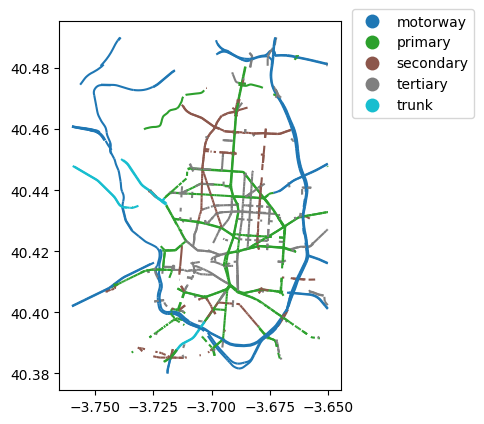

In [80]:
# Filter less empty roads
filtered = road_stats_[road_stats_["t"]>96*0.95]
road_filtered = road.merge(filtered[["t"]],on="gkey")
# Clip if its too large
mask = (-3.76,40.38,-3.65,40.49) # (minx, miny, maxx, maxy)
road_filtered = gpd.clip(road_filtered, mask, keep_geom_type=True)
filtered = road_filtered[["gkey","t"]].set_index("gkey")

road_filtered.plot(column="highway", legend=True,legend_kwds={'bbox_to_anchor': (1.5, 1.05)})

print(road_filtered.shape)

In [73]:
# Save filtered roads
output_dir = root /"adj"/ f"{city}_allcat"
if not output_dir.exists():
    output_dir.mkdir(parents=True)

filtered[["t"]].to_csv(output_dir/"filtered_road_gkeys.csv")

array([[<Axes: title={'center': 'motorway'}>,
        <Axes: title={'center': 'primary'}>],
       [<Axes: title={'center': 'secondary'}>,
        <Axes: title={'center': 'trunk'}>]], dtype=object)

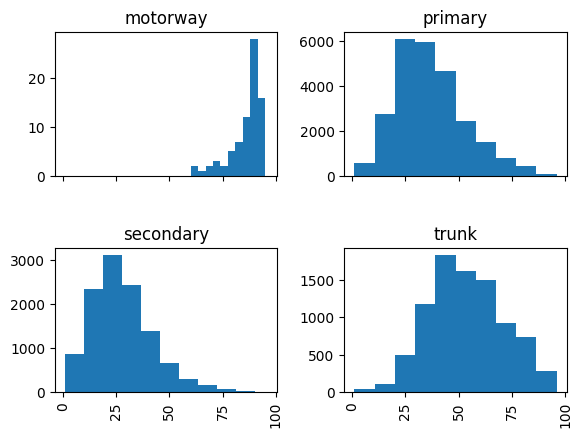

In [7]:
road_stats_.hist(column="t",by="highway",sharex=True)

70 / 78 have missing records


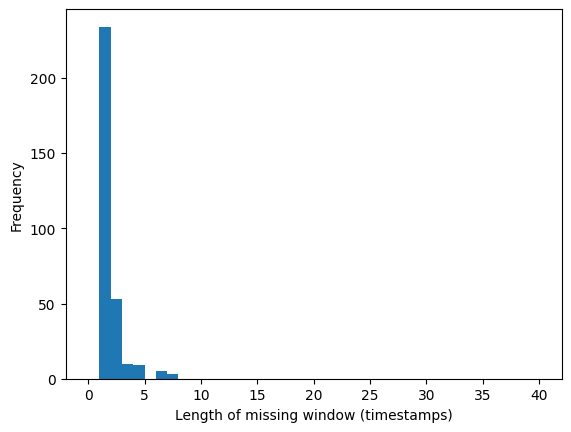

In [60]:
# Missing Window Size
road_type = "motorway"
gkeys = road[road["highway"].isin([road_type])]["gkey"].tolist()
df_selected = df[df["gkey"].isin(gkeys)]

window_gaps = []
for gkey in gkeys:
    selected = df[df["gkey"]==gkey].sort_values(by="t")
    t = selected["t"].values
    window_gap = t[1:] - t[:-1]
    window_gap = window_gap - 1
    window_gap = window_gap[window_gap!=0]
    if window_gap.shape[0]>0:
        window_gaps.append(window_gap)
print(f"{len(window_gaps)} / {len(gkeys)} have missing records")

window_gaps = [__ for _ in window_gaps for __ in _]


# Plot: Distribution of missing window size
plt.hist(window_gaps, bins=40,range=(0,40))
plt.xlabel("Length of missing window (timestamps)")
plt.ylabel("Frequency")
plt.savefig(f"./fig/missing_window_length-{city}_{road_type}.png",bbox_inches="tight")
plt.show()

## Missing data imputation

# Road Map

In [44]:
# Read geo road
geo_path = "/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022/road_graph/melbourne/road_graph.gpkg"

geo = gpd.read_file(geo_path, layer="edges")

In [21]:
geo.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,reversed,length,...,travel_time,lanes,ref,bridge,junction,access,width,tunnel,service,geometry
0,579260,814333,0,4709644,Main Road,secondary,60,False,True,42.355,...,2.5,,,,,,,,,"LINESTRING (145.12669 -37.93883, 145.12661 -37..."
1,579260,32999237,0,4709644,Main Road,secondary,60,False,False,362.945,...,21.8,,,,,,,,,"LINESTRING (145.12669 -37.93883, 145.12713 -37..."
2,579260,579352,0,4709649,Rosebank Avenue,tertiary,60,False,False,108.784,...,6.5,,,,,,,,,"LINESTRING (145.12669 -37.93883, 145.12675 -37..."
3,579265,32999151,0,"[24965954, 125494026, 19141419, 137293622, 137...",Westall Road,primary,80,True,False,457.712,...,21.2,3,49,yes,,,,,,"LINESTRING (145.14072 -37.93702, 145.14044 -37..."
4,579267,32075354,0,569765776,Wellington Road,trunk,80,True,False,15.405,...,0.7,3,18,,,,,,,"LINESTRING (145.14004 -37.91617, 145.14021 -37..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


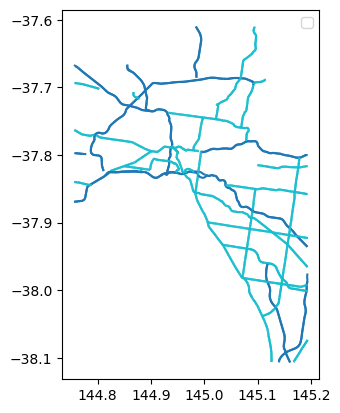

In [36]:
geo[geo["highway"].isin(["motorway","trunk"])].plot(column="highway", )
plt.show()

In [11]:
# check adj matrix

path = "/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022/road_graph/melbourne"

adj = np.load(Path(path)/"adjacency_mat_filtered.npy")
print(adj.shape)

In [14]:
# check train daily
import h5py
path = "/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022/speed_train_daily/melbourne/speed_filtered_2020-06-01.h5"

c_sample = h5py.File(path,'r')['data']

In [15]:
c_sample.shape

(96, 350, 3)